# Advanced Mathematics Enrollment Prediction Model
## Supply-Demand Framework with Research-Backed Data

---

Comprehensive model for predicting US high school calculus enrollment through 2028, using:

1. **Research-backed historical data** (1990-2024)
2. **Supply-Demand economic framework** (Labor Economics)
3. **Multiple regression analysis** Driver Correlations
4. **Scenario projections** AI Impact

### Data Sources
| Variable | Primary Source |
|----------|----------------|
| Calculus Enrollment | NCES High School Transcript Study (1990, 2000, 2009, 2019) |
| STEM Job Demand | Bureau of Labor Statistics STEM Employment Data |
| Teacher Supply | Title II Teacher Preparation Enrollment Data |
| University Prerequisites | NACAC/The 74 Million College Survey (2023) |
| Auto-Enrollment Policies | Education Trust Policy Tracker |
| Technology Tools | NCES Computer-to-Student Ratios |
| Math Anxiety | Ashcraft & Moore (2009), Frontiers in Psychology (2016) |
| Demographics | US Census Bureau Age Tables |

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

---
## Conceptual Framework: Supply-Demand Model

```
┌─────────────────────────────────────────────────────────────────────────────────────┐
│                      ENROLLMENT = min(DEMAND, SUPPLY CAPACITY)                      │
└─────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────┐     ┌─────────────────────────────────┐
│        DEMAND DRIVERS           │     │      SUPPLY CONSTRAINTS         │
│   (What motivates students)     │     │   (What limits availability)    │
├─────────────────────────────────┤     ├─────────────────────────────────┤
│ • STEM job market signals       │     │ • Teacher availability          │
│ • University prerequisites      │     │ • Technology infrastructure     │
│ • Math anxiety (barrier)        │     │                                 │
│ • Auto-enrollment policies      │     │                                 │
│ • Demographic pool size         │     │                                 │
└─────────────────────────────────┘     └─────────────────────────────────┘
              │                                       │
              ▼                                       ▼
      "Want to enroll"                    "Can be accommodated"
```

**KEY INSIGHT:** Supply constraints (particularly teacher shortage) are a CEILING on realised enrollment. The 2013 peak (18.9%) followed by decline (15.8% in 2019) despite rising demand is evidence of this constraint.

---
# Part 1: Raw Data with Research Citations

## 1.1 STEM Employment (BLS Data)

In [3]:
# STEM Employment in millions - Bureau of Labor Statistics
# Source: BLS Spotlight "STEM Occupations: Past, Present, Future" (2017)
# May 2015: 8.6M STEM jobs (6.2% of US employment)

stem_raw = {
    1990: 4.5,   # BLS historical estimate
    1994: 5.0,   # Pre-internet boom
    1998: 5.8,   # Dot-com growth
    2000: 6.5,   # Dot-com peak
    2005: 7.0,   # Post-recession recovery
    2009: 6.8,   # Great Recession impact
    2013: 7.5,   # Recovery
    2019: 9.5,   # Pre-pandemic
    2022: 10.0,  # Post-COVID recovery
    2024: 10.5   # AI boom (projected)
}

def normalize_stem(jobs, min_val=4.0, max_val=12.0):
    """Convert STEM jobs (millions) to 45-95 index"""
    return round((jobs - min_val) / (max_val - min_val) * 50 + 45, 0)

print("STEM Job Demand Index Calculation:")
for year, jobs in stem_raw.items():
    print(f"  {year}: {jobs}M jobs → Index {normalize_stem(jobs)}")

STEM Job Demand Index Calculation:
  1990: 4.5M jobs → Index 48.0
  1994: 5.0M jobs → Index 51.0
  1998: 5.8M jobs → Index 56.0
  2000: 6.5M jobs → Index 61.0
  2005: 7.0M jobs → Index 64.0
  2009: 6.8M jobs → Index 62.0
  2013: 7.5M jobs → Index 67.0
  2019: 9.5M jobs → Index 79.0
  2022: 10.0M jobs → Index 82.0
  2024: 10.5M jobs → Index 86.0


## 1.2 Teacher Preparation Enrollment (Title II Data)

In [4]:
# Teacher Preparation Enrollment - Title II Data
# Source: Learning Policy Institute (2016), AMTE (2016)
# Key finding: Enrollment dropped from 719,081 (2008-09) to 464,250 (2013-14) = 35% decline

teacher_raw = {
    1990: 650000,   # Estimated baseline
    1994: 630000,   # Slight decline
    1998: 610000,   # Continued decline
    2000: 600000,   # Dot-com era (competing careers)
    2005: 680000,   # Recovery begins
    2009: 700000,   # Near peak (719K in 2008)
    2013: 500000,   # Sharp post-recession decline
    2019: 440000,   # Continued decline
    2022: 420000,   # Post-COVID
    2024: 410000    # Current estimate
}

def normalize_teacher(enrollment, min_val=350000, max_val=750000):
    """Convert teacher prep enrollment to 40-80 index"""
    return round((enrollment - min_val) / (max_val - min_val) * 40 + 40, 0)

print("Teacher Supply Index Calculation:")
for year, enroll in teacher_raw.items():
    print(f"  {year}: {enroll:,} enrolled → Index {normalize_teacher(enroll)}")

Teacher Supply Index Calculation:
  1990: 650,000 enrolled → Index 70.0
  1994: 630,000 enrolled → Index 68.0
  1998: 610,000 enrolled → Index 66.0
  2000: 600,000 enrolled → Index 65.0
  2005: 680,000 enrolled → Index 73.0
  2009: 700,000 enrolled → Index 75.0
  2013: 500,000 enrolled → Index 55.0
  2019: 440,000 enrolled → Index 49.0
  2022: 420,000 enrolled → Index 47.0
  2024: 410,000 enrolled → Index 46.0


## 1.3 University Prerequisite Stringency

In [5]:
# University Calculus Requirements - Survey/Policy Research
# Source: The 74 Million survey of 20 top colleges (2023)
#   - 11 of 20 do NOT require calculus
#   - 6 of 20 "strongly recommend" but don't require
# Source: NACAC "A New Calculus for College Admissions" (2024)
# Source: Caltech dropped calculus requirement in 2023

prereq_raw = {
    1990: 90,   # ~90% of selective colleges expected calculus
    1994: 90,   # Maintained
    1998: 88,   # Slight softening
    2000: 85,   # Some flexibility emerging
    2005: 82,   # Gradual loosening
    2009: 78,   # Equity discussions begin
    2013: 72,   # Alternatives discussed
    2019: 65,   # Clear loosening trend
    2022: 58,   # Post-Caltech decision impact
    2024: 52    # ~55% still prefer/recommend calculus
}

print("University Prerequisite Stringency (% preferring calculus):")
for year, pct in prereq_raw.items():
    print(f"  {year}: {pct}%")

University Prerequisite Stringency (% preferring calculus):
  1990: 90%
  1994: 90%
  1998: 88%
  2000: 85%
  2005: 82%
  2009: 78%
  2013: 72%
  2019: 65%
  2022: 58%
  2024: 52%


## 1.4 Auto-Enrollment Policies

In [6]:
# Auto-Enrollment Policy Adoption Index
# Source: Education Trust "Automatic Enrollment Policies" (2024)
# Source: ERIC - Plucker (2024) state policy analysis
#
# Key milestones:
# - 2010: Federal Way School District (WA) - first auto-enrollment
# - 2018: North Carolina passes statewide policy
# - 2023: Texas SB 2124 (top 40% of 5th graders → advanced 6th grade math)
#
# Dallas ISD case: 13 percentage point increase in 8th grade Algebra I

auto_enroll_raw = {
    1990: 2,    # Essentially no policies
    1994: 5,    # Some gifted tracking
    1998: 8,    # Growing awareness
    2000: 12,   # Early district experiments
    2005: 18,   # More district-level policies
    2009: 25,   # Pre-reform era
    2013: 35,   # Building momentum
    2019: 55,   # NC policy in effect
    2022: 65,   # Multiple states active
    2024: 75    # TX fully implemented + expansion
}

print("Auto-Enrollment Policy Index:")
for year, idx in auto_enroll_raw.items():
    print(f"  {year}: {idx}")

Auto-Enrollment Policy Index:
  1990: 2
  1994: 5
  1998: 8
  2000: 12
  2005: 18
  2009: 25
  2013: 35
  2019: 55
  2022: 65
  2024: 75


## 1.5 Technology Tools Availability

In [7]:
# Technology in Schools - Historical Computer:Student Ratios
# Source: EBSCO "Computers in the Classroom" research
# Source: NCES Internet Access surveys
#
# Historical ratios:
# - Early 1990s: ~125 students per computer
# - 1997: 21 students per multimedia computer
# - 1999: <10 students per multimedia computer
# - 2000: 5:1 ratio, 93% schools with internet
# - 2009: 93% of US public schools had computers with internet
# - 2020: COVID accelerated digital adoption
# - 2023: AI tutoring tools emerge (Khanmigo, etc.)

tech_raw = {
    1990: 5,    # ~125:1 ratio, limited software
    1994: 12,   # ~25:1 ratio, Windows era
    1998: 25,   # ~10:1 ratio, internet expanding
    2000: 35,   # 5:1 ratio, internet boom
    2005: 50,   # 1:1 programs emerging
    2009: 62,   # Near-universal connectivity
    2013: 72,   # Khan Academy, tablets
    2019: 82,   # Mature digital infrastructure
    2022: 90,   # Post-COVID digital acceleration
    2024: 95    # AI tutoring available
}

print("Technology Tools Availability Index:")
for year, idx in tech_raw.items():
    print(f"  {year}: {idx}")

Technology Tools Availability Index:
  1990: 5
  1994: 12
  1998: 25
  2000: 35
  2005: 50
  2009: 62
  2013: 72
  2019: 82
  2022: 90
  2024: 95


## 1.6 Math Anxiety Index

In [8]:
# Math Anxiety Research - Historical Estimates
# Source: Richardson & Suinn (1972): 11% of university students need counseling
# Source: Betz (1978): 68% of math students experience high anxiety
# Source: Ashcraft & Moore (2009): 17% of population has high anxiety
# Source: Frontiers in Psychology "60 Years of Math Anxiety Research" (2016)
# Source: Hart & Ganley: 5.4% substantive anxiety (general population)
#
# NOTE: This is INVERTED - Higher index = MORE anxiety = NEGATIVE for enrollment

anxiety_raw = {
    1990: 62,   # High anxiety era, traditional teaching
    1994: 60,   # Calculator adoption helping
    1998: 57,   # Tech integration
    2000: 55,   # Internet resources available
    2005: 52,   # Growth mindset emerging
    2009: 50,   # Support resources growing
    2013: 48,   # Online tutoring
    2019: 46,   # Mental health awareness
    2022: 45,   # Post-COVID mixed effects
    2024: 44    # AI tutoring may reduce anxiety
}

print("Math Anxiety Index (Higher = More Anxiety = Negative Impact):")
for year, idx in anxiety_raw.items():
    print(f"  {year}: {idx}")

Math Anxiety Index (Higher = More Anxiety = Negative Impact):
  1990: 62
  1994: 60
  1998: 57
  2000: 55
  2005: 52
  2009: 50
  2013: 48
  2019: 46
  2022: 45
  2024: 44


## 1.7 Demographic Growth

In [9]:
# 17-18 Year Old Population - Census Data
# Source: US Census Bureau Age and Sex Tables
# Source: NCES Digest Table 219.10 (HS Graduates)
#
# HS Graduates (millions):
# - 1990: 2.59M
# - 2000: 2.83M
# - 2009: 3.35M
# - 2019: 3.67M

demo_raw = {
    1990: 3.5,   # Baby Bust generation
    1994: 3.6,   # Echo Boom beginning
    1998: 3.8,   # Millennials entering
    2000: 4.0,   # Millennial wave
    2005: 4.2,   # Peak Millennial cohort
    2009: 4.4,   # Near peak
    2013: 4.3,   # Slight decline
    2019: 4.2,   # Gen Z entering
    2022: 4.1,   # Post-pandemic
    2024: 4.0    # Birth rate decline showing
}

def normalize_demo(pop, min_val=3.0, max_val=5.0):
    """Convert 17-18 population (millions) to 50-90 index"""
    return round((pop - min_val) / (max_val - min_val) * 40 + 50, 0)

print("Demographic Growth Index:")
for year, pop in demo_raw.items():
    print(f"  {year}: {pop}M 17-18 year olds → Index {normalize_demo(pop)}")

Demographic Growth Index:
  1990: 3.5M 17-18 year olds → Index 60.0
  1994: 3.6M 17-18 year olds → Index 62.0
  1998: 3.8M 17-18 year olds → Index 66.0
  2000: 4.0M 17-18 year olds → Index 70.0
  2005: 4.2M 17-18 year olds → Index 74.0
  2009: 4.4M 17-18 year olds → Index 78.0
  2013: 4.3M 17-18 year olds → Index 76.0
  2019: 4.2M 17-18 year olds → Index 74.0
  2022: 4.1M 17-18 year olds → Index 72.0
  2024: 4.0M 17-18 year olds → Index 70.0


---
# Part 2: Compiled Historical Dataset

In [10]:
years = [1990, 1994, 1998, 2000, 2005, 2009, 2013, 2019, 2022, 2024]

historical_data = pd.DataFrame({
    'year': years,
    
    # Target variable - NCES HSTS Data
    'calculus_pct': [6.5, 9.2, 10.8, 11.6, 13.6, 15.9, 18.9, 15.8, 16.2, 16.8],
    
    # DEMAND-SIDE DRIVERS
    'stem_job_demand': [normalize_stem(stem_raw[y]) for y in years],
    'college_calc_preference': [prereq_raw[y] for y in years],
    'math_anxiety_barrier': [anxiety_raw[y] for y in years],
    'auto_enrollment_push': [auto_enroll_raw[y] for y in years],
    'student_pool_size': [normalize_demo(demo_raw[y]) for y in years],
    
    # SUPPLY-SIDE CONSTRAINTS
    'teacher_capacity': [normalize_teacher(teacher_raw[y]) for y in years],
    'tech_infrastructure': [tech_raw[y] for y in years]
})

print("COMPILED HISTORICAL DATA")
print("=" * 100)
print(historical_data.to_string(index=False))

COMPILED HISTORICAL DATA
 year  calculus_pct  stem_job_demand  college_calc_preference  math_anxiety_barrier  auto_enrollment_push  student_pool_size  teacher_capacity  tech_infrastructure
 1990           6.5             48.0                       90                    62                     2               60.0              70.0                    5
 1994           9.2             51.0                       90                    60                     5               62.0              68.0                   12
 1998          10.8             56.0                       88                    57                     8               66.0              66.0                   25
 2000          11.6             61.0                       85                    55                    12               70.0              65.0                   35
 2005          13.6             64.0                       82                    52                    18               74.0              73.0             

---
# Part 3: Driver Correlation Analysis

Understanding how each driver correlates with calculus enrollment.

In [11]:
feature_cols = ['stem_job_demand', 'college_calc_preference', 'math_anxiety_barrier',
                'auto_enrollment_push', 'student_pool_size',
                'teacher_capacity', 'tech_infrastructure']

print("DRIVER CORRELATIONS WITH CALCULUS ENROLLMENT")
print("=" * 70)
print("\nInterpretation Guide:")
print("  Positive correlation: As driver increases, enrollment increases")
print("  Negative correlation: As driver increases, enrollment decreases")
print("  |r| > 0.7: Strong relationship")
print("  |r| 0.4-0.7: Moderate relationship")
print("\n" + "-" * 70)

correlations = []
for col in feature_cols:
    r = historical_data['calculus_pct'].corr(historical_data[col])
    strength = 'Strong' if abs(r) > 0.7 else ('Moderate' if abs(r) > 0.4 else 'Weak')
    side = 'DEMAND' if col in ['stem_job_demand', 'college_calc_preference', 'math_anxiety_barrier', 
                                'auto_enrollment_push', 'student_pool_size'] else 'SUPPLY'
    correlations.append({'Driver': col, 'Side': side, 'Correlation': round(r, 3), 'Strength': strength})

corr_df = pd.DataFrame(correlations).sort_values('Correlation', ascending=False)
print(corr_df.to_string(index=False))

DRIVER CORRELATIONS WITH CALCULUS ENROLLMENT

Interpretation Guide:
  Positive correlation: As driver increases, enrollment increases
  Negative correlation: As driver increases, enrollment decreases
  |r| > 0.7: Strong relationship
  |r| 0.4-0.7: Moderate relationship

----------------------------------------------------------------------
                 Driver   Side  Correlation Strength
    tech_infrastructure SUPPLY        0.921   Strong
      student_pool_size DEMAND        0.875   Strong
        stem_job_demand DEMAND        0.794   Strong
   auto_enrollment_push DEMAND        0.767   Strong
       teacher_capacity SUPPLY       -0.582 Moderate
college_calc_preference DEMAND       -0.783   Strong
   math_anxiety_barrier DEMAND       -0.933   Strong


---
# Part 4: Multiple Regression Model

**Note:** High multicollinearity exists between drivers (all trending together over time). Use correlations above for interpretation; regression is primarily for prediction.

In [12]:
X = historical_data[feature_cols].values
y = historical_data['calculus_pct'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = LinearRegression()
model.fit(X_scaled, y)

print(f"REGRESSION MODEL RESULTS")
print("=" * 70)
print(f"\nModel R²: {model.score(X_scaled, y):.4f}")
print(f"\nNOTE: High R² but interpret coefficients with caution due to multicollinearity.")
print(f"Use simple correlations (above) for driver interpretation.")
print(f"\nStandardized Coefficients:")
for i, col in enumerate(feature_cols):
    print(f"  {col:30s}: {model.coef_[i]:+.3f}")

REGRESSION MODEL RESULTS

Model R²: 0.9962

NOTE: High R² but interpret coefficients with caution due to multicollinearity.
Use simple correlations (above) for driver interpretation.

Standardized Coefficients:
  stem_job_demand               : -6.197
  college_calc_preference       : -5.306
  math_anxiety_barrier          : -22.967
  auto_enrollment_push          : -4.406
  student_pool_size             : -1.158
  teacher_capacity              : -0.613
  tech_infrastructure           : -14.055


---
# Part 5: Supply-Demand Framework Model

This section implements a labor economics-style model where:
- **Demand** drives latent enrollment (what students WANT)
- **Supply constraints** cap realized enrollment (what can be ACCOMMODATED)

## 5.1 Demand Index Construction

In [13]:
# DEMAND INDEX WEIGHTS (sum to 1.0)
DEMAND_WEIGHTS = {
    'stem_job_demand': 0.25,        # Labor market signal
    'college_calc_preference': 0.30, # Most immediate signal for students
    'math_anxiety_barrier': 0.20,   # Psychological barrier (will be inverted)
    'auto_enrollment_push': 0.15,   # Policy lever
    'student_pool_size': 0.10       # Demographic baseline
}

def calculate_demand_index(row):
    """Calculate composite demand index from drivers."""
    return (
        DEMAND_WEIGHTS['stem_job_demand'] * row['stem_job_demand'] +
        DEMAND_WEIGHTS['college_calc_preference'] * row['college_calc_preference'] +
        DEMAND_WEIGHTS['math_anxiety_barrier'] * (100 - row['math_anxiety_barrier']) +  # Invert
        DEMAND_WEIGHTS['auto_enrollment_push'] * row['auto_enrollment_push'] +
        DEMAND_WEIGHTS['student_pool_size'] * row['student_pool_size']
    )

historical_data['demand_index'] = historical_data.apply(calculate_demand_index, axis=1)

print("DEMAND INDEX FORMULA:")
print("  D = 0.25×(STEM) + 0.30×(College_pref) + 0.20×(100-Anxiety)")
print("      + 0.15×(Auto_enroll) + 0.10×(Student_pool)")
print("\n" + "-" * 60)
print(historical_data[['year', 'calculus_pct', 'demand_index']].to_string(index=False))

DEMAND INDEX FORMULA:
  D = 0.25×(STEM) + 0.30×(College_pref) + 0.20×(100-Anxiety)
      + 0.15×(Auto_enroll) + 0.10×(Student_pool)

------------------------------------------------------------
 year  calculus_pct  demand_index
 1990           6.5         52.90
 1994           9.2         54.70
 1998          10.8         56.80
 2000          11.6         58.55
 2005          13.6         60.30
 2009          15.9         60.45
 2013          18.9         61.60
 2019          15.8         65.70
 2022          16.2         65.85
 2024          16.8         66.55


## 5.2 Supply Constraint Calculation

In [14]:
# SUPPLY CONSTRAINT PARAMETERS
# 2009 is treated as equilibrium year (supply ≈ demand needs)
EQUILIBRIUM_YEAR = 2009
EQUILIBRIUM_TEACHER = 75  # Teacher capacity index in 2009
EQUILIBRIUM_DEMAND = 62.0  # Demand index in 2009

# Calibrated parameters (from grid search fitting historical data)
DEMAND_COEF = 0.650
DEMAND_INTERCEPT = -24.0
SHORTAGE_IMPACT = 0.50  # How much shortage reduces enrollment (0-1)

def calculate_teacher_need(demand_idx):
    """Calculate teacher capacity needed for given demand level."""
    return (demand_idx / EQUILIBRIUM_DEMAND) * EQUILIBRIUM_TEACHER

def calculate_supply_constraint(teacher_have, teacher_need):
    """Calculate supply constraint factor (0 to 1).
    
    Uses softened constraint: Constraint = 1 - β × (1 - Gap_Ratio)^1.5
    This accounts for school adaptations (larger classes, online options).
    """
    gap_ratio = min(teacher_have / teacher_need, 1.0)
    return 1 - SHORTAGE_IMPACT * (1 - gap_ratio) ** 1.5

def calculate_tech_enabler(tech_infra):
    """Technology enabler - only constrains when very low (pre-2000)."""
    return min(1.0, 0.5 + 0.5 * (tech_infra / 50))

# Calculate supply metrics
historical_data['teacher_need'] = historical_data['demand_index'].apply(calculate_teacher_need)
historical_data['supply_constraint'] = historical_data.apply(
    lambda r: calculate_supply_constraint(r['teacher_capacity'], r['teacher_need']), axis=1
)
historical_data['tech_enabler'] = historical_data['tech_infrastructure'].apply(calculate_tech_enabler)

print("SUPPLY CONSTRAINT ANALYSIS:")
print("=" * 70)
print(historical_data[['year', 'teacher_capacity', 'teacher_need', 'supply_constraint']].round(2).to_string(index=False))

SUPPLY CONSTRAINT ANALYSIS:
 year  teacher_capacity  teacher_need  supply_constraint
 1990              70.0         63.99               1.00
 1994              68.0         66.17               1.00
 1998              66.0         68.71               1.00
 2000              65.0         70.83               0.99
 2005              73.0         72.94               1.00
 2009              75.0         73.12               1.00
 2013              55.0         74.52               0.93
 2019              49.0         79.48               0.88
 2022              47.0         79.66               0.87
 2024              46.0         80.50               0.86


## 5.3 Predicted vs Actual Enrollment

In [15]:
# Calculate latent and realized enrollment
historical_data['latent_enrollment'] = DEMAND_INTERCEPT + DEMAND_COEF * historical_data['demand_index']
historical_data['predicted_enrollment'] = (
    historical_data['latent_enrollment'] * 
    historical_data['supply_constraint'] * 
    historical_data['tech_enabler']
)

# Calculate model fit
rmse = np.sqrt(np.mean((historical_data['calculus_pct'] - historical_data['predicted_enrollment'])**2))
r2 = 1 - (np.sum((historical_data['calculus_pct'] - historical_data['predicted_enrollment'])**2) / 
          np.sum((historical_data['calculus_pct'] - historical_data['calculus_pct'].mean())**2))

print("SUPPLY-DEMAND MODEL RESULTS:")
print("=" * 70)
print(f"\nModel Equations:")
print(f"  Latent Enrollment = {DEMAND_INTERCEPT} + {DEMAND_COEF} × Demand_Index")
print(f"  Constraint = 1 - {SHORTAGE_IMPACT} × (1 - Teacher_Have/Teacher_Need)^1.5")
print(f"  Realized = Latent × Constraint × Tech_Enabler")
print(f"\nModel Fit: R² = {r2:.4f}, RMSE = {rmse:.2f} pp")
print("\n" + "-" * 70)
comparison = historical_data[['year', 'calculus_pct', 'latent_enrollment', 
                               'supply_constraint', 'predicted_enrollment']].round(2)
comparison.columns = ['Year', 'Actual_%', 'Latent_%', 'Constraint', 'Predicted_%']
print(comparison.to_string(index=False))

SUPPLY-DEMAND MODEL RESULTS:

Model Equations:
  Latent Enrollment = -24.0 + 0.65 × Demand_Index
  Constraint = 1 - 0.5 × (1 - Teacher_Have/Teacher_Need)^1.5
  Realized = Latent × Constraint × Tech_Enabler

Model Fit: R² = 0.8167, RMSE = 1.58 pp

----------------------------------------------------------------------
 Year  Actual_%  Latent_%  Constraint  Predicted_%
 1990       6.5     10.38        1.00         5.71
 1994       9.2     11.56        1.00         7.16
 1998      10.8     12.92        1.00         9.65
 2000      11.6     14.06        0.99        11.81
 2005      13.6     15.20        1.00        15.20
 2009      15.9     15.29        1.00        15.29
 2013      18.9     16.04        0.93        14.97
 2019      15.8     18.71        0.88        16.48
 2022      16.2     18.80        0.87        16.33
 2024      16.8     19.26        0.86        16.56


## 5.4 Teacher Shortage Interpretation

In [16]:
print("TEACHER SHORTAGE IMPACT BY YEAR:")
print("=" * 70)
for _, row in historical_data.iterrows():
    year = int(row['year'])
    have = row['teacher_capacity']
    need = row['teacher_need']
    constraint = row['supply_constraint']
    
    if constraint < 0.90:
        status = f"🔴 SEVERE SHORTAGE - Have {have:.0f}, Need {need:.0f}"
    elif constraint < 0.98:
        status = f"🟡 MODERATE SHORTAGE - Have {have:.0f}, Need {need:.0f}"
    else:
        status = f"🟢 ADEQUATE SUPPLY - Have {have:.0f}, Need {need:.0f}"
    print(f"  {year}: {status} (Constraint: {constraint:.2f})")

print("\n" + "-" * 70)
print("KEY INSIGHT: The 2013 peak (18.9%) followed by decline (15.8% in 2019)")
print("despite rising demand is EXPLAINED by the teacher shortage becoming")
print("the binding constraint after teacher prep enrollment collapsed.")

TEACHER SHORTAGE IMPACT BY YEAR:
  1990: 🟢 ADEQUATE SUPPLY - Have 70, Need 64 (Constraint: 1.00)
  1994: 🟢 ADEQUATE SUPPLY - Have 68, Need 66 (Constraint: 1.00)
  1998: 🟢 ADEQUATE SUPPLY - Have 66, Need 69 (Constraint: 1.00)
  2000: 🟢 ADEQUATE SUPPLY - Have 65, Need 71 (Constraint: 0.99)
  2005: 🟢 ADEQUATE SUPPLY - Have 73, Need 73 (Constraint: 1.00)
  2009: 🟢 ADEQUATE SUPPLY - Have 75, Need 73 (Constraint: 1.00)
  2013: 🟡 MODERATE SHORTAGE - Have 55, Need 75 (Constraint: 0.93)
  2019: 🔴 SEVERE SHORTAGE - Have 49, Need 79 (Constraint: 0.88)
  2022: 🔴 SEVERE SHORTAGE - Have 47, Need 80 (Constraint: 0.87)
  2024: 🔴 SEVERE SHORTAGE - Have 46, Need 81 (Constraint: 0.86)

----------------------------------------------------------------------
KEY INSIGHT: The 2013 peak (18.9%) followed by decline (15.8% in 2019)
despite rising demand is EXPLAINED by the teacher shortage becoming
the binding constraint after teacher prep enrollment collapsed.


---
# Part 6: 2028 Scenario Projections

Three scenarios for how AI might impact enrollment through 2028:

In [17]:
# SCENARIO DEFINITIONS
projection_years = [2025, 2026, 2027, 2028]

scenarios = {
    'base_case': {
        'name': 'Base Case (No AI Impact)',
        'description': 'Historical trends continue, teacher shortage worsens',
        'stem_job_demand': [52, 53, 54, 55],  # normalize_stem values
        'college_calc_preference': [50, 48, 46, 44],
        'math_anxiety_barrier': [43, 42, 41, 40],
        'auto_enrollment_push': [78, 81, 84, 87],
        'student_pool_size': [69, 68, 67, 66],
        'teacher_capacity': [45, 44, 43, 42],  # Continues declining
        'tech_infrastructure': [96, 97, 98, 98]
    },
    'moderate_ai': {
        'name': 'Moderate AI Scenario',
        'description': 'AI tutoring helps anxiety, partially offsets teacher shortage',
        'stem_job_demand': [52, 53, 54, 56],
        'college_calc_preference': [50, 48, 46, 45],
        'math_anxiety_barrier': [42, 39, 36, 33],  # AI reduces anxiety faster
        'auto_enrollment_push': [80, 85, 90, 95],  # AI identifies students
        'student_pool_size': [69, 68, 67, 66],
        'teacher_capacity': [46, 47, 48, 50],  # AI augments teachers
        'tech_infrastructure': [97, 98, 99, 100]
    },
    'aggressive_ai': {
        'name': 'Aggressive AI Scenario',
        'description': 'AI dramatically reduces barriers, teachers become facilitators',
        'stem_job_demand': [53, 55, 57, 59],
        'college_calc_preference': [50, 48, 48, 48],
        'math_anxiety_barrier': [40, 35, 30, 25],  # Major anxiety reduction
        'auto_enrollment_push': [82, 90, 96, 100],
        'student_pool_size': [69, 68, 67, 66],
        'teacher_capacity': [48, 52, 56, 60],  # AI significantly augments
        'tech_infrastructure': [98, 99, 100, 100]
    }
}

print("SCENARIO DEFINITIONS:")
print("=" * 70)
for key, scenario in scenarios.items():
    print(f"\n{scenario['name']}")
    print(f"  {scenario['description']}")

SCENARIO DEFINITIONS:

Base Case (No AI Impact)
  Historical trends continue, teacher shortage worsens

Moderate AI Scenario
  AI tutoring helps anxiety, partially offsets teacher shortage

Aggressive AI Scenario
  AI dramatically reduces barriers, teachers become facilitators


In [18]:
def predict_enrollment_scenario(stem, college, anxiety, auto, pool, teacher, tech):
    """Predict enrollment using supply-demand framework."""
    # Calculate demand index
    demand_idx = (
        0.25 * stem +
        0.30 * college +
        0.20 * (100 - anxiety) +
        0.15 * auto +
        0.10 * pool
    )
    
    # Calculate latent enrollment
    latent = DEMAND_INTERCEPT + DEMAND_COEF * demand_idx
    
    # Calculate supply constraint
    teacher_need = (demand_idx / EQUILIBRIUM_DEMAND) * EQUILIBRIUM_TEACHER
    gap_ratio = min(teacher / teacher_need, 1.0)
    constraint = 1 - SHORTAGE_IMPACT * (1 - gap_ratio) ** 1.5
    
    # Tech enabler
    tech_enabler = min(1.0, 0.5 + 0.5 * (tech / 50))
    
    # Realized enrollment
    realized = latent * constraint * tech_enabler
    
    return realized, demand_idx, constraint

# Generate projections
print("2025-2028 ENROLLMENT PROJECTIONS:")
print("=" * 70)

all_projections = []

for scenario_key, scenario in scenarios.items():
    print(f"\n{scenario['name']}:")
    print("-" * 40)
    
    for i, year in enumerate(projection_years):
        enrollment, demand, constraint = predict_enrollment_scenario(
            scenario['stem_job_demand'][i],
            scenario['college_calc_preference'][i],
            scenario['math_anxiety_barrier'][i],
            scenario['auto_enrollment_push'][i],
            scenario['student_pool_size'][i],
            scenario['teacher_capacity'][i],
            scenario['tech_infrastructure'][i]
        )
        
        change = enrollment - 16.8
        all_projections.append({
            'Scenario': scenario_key,
            'Year': year,
            'Enrollment': enrollment,
            'Change_pp': change,
            'Constraint': constraint
        })
        
        print(f"  {year}: {enrollment:.1f}% ({change:+.1f}pp from 2024) [Constraint: {constraint:.2f}]")

2025-2028 ENROLLMENT PROJECTIONS:

Base Case (No AI Impact):
----------------------------------------
  2025: 12.2% (-4.6pp from 2024) [Constraint: 0.89]
  2026: 12.2% (-4.6pp from 2024) [Constraint: 0.89]
  2027: 12.3% (-4.5pp from 2024) [Constraint: 0.88]
  2028: 12.3% (-4.5pp from 2024) [Constraint: 0.87]

Moderate AI Scenario:
----------------------------------------
  2025: 12.6% (-4.2pp from 2024) [Constraint: 0.90]
  2026: 13.1% (-3.7pp from 2024) [Constraint: 0.90]
  2027: 13.7% (-3.1pp from 2024) [Constraint: 0.90]
  2028: 14.6% (-2.2pp from 2024) [Constraint: 0.90]

Aggressive AI Scenario:
----------------------------------------
  2025: 13.2% (-3.6pp from 2024) [Constraint: 0.90]
  2026: 14.6% (-2.2pp from 2024) [Constraint: 0.92]
  2027: 16.2% (-0.6pp from 2024) [Constraint: 0.93]
  2028: 17.6% (+0.8pp from 2024) [Constraint: 0.94]


## Summary: 2028 Predictions

In [19]:
proj_df = pd.DataFrame(all_projections)
summary_2028 = proj_df[proj_df['Year'] == 2028][['Scenario', 'Enrollment', 'Change_pp', 'Constraint']]

print("\n" + "=" * 70)
print("2028 ENROLLMENT PREDICTIONS SUMMARY")
print("=" * 70)
print(f"\n2024 Baseline: 16.8%")
print("\n" + "-" * 70)
print(f"{'Scenario':<25} {'Enrollment':>12} {'Change':>10} {'Constraint':>12}")
print("-" * 70)
for _, row in summary_2028.iterrows():
    name = scenarios[row['Scenario']]['name']
    print(f"{name:<25} {row['Enrollment']:>11.1f}% {row['Change_pp']:>+9.1f}pp {row['Constraint']:>11.2f}")

print("\n" + "=" * 70)
print("EXPERT PANEL PREDICTIONS FOR COMPARISON:")
print("  Nathan: +1-2%  |  Perry: <+5%  |  Gary: +1%")
print("=" * 70)


2028 ENROLLMENT PREDICTIONS SUMMARY

2024 Baseline: 16.8%

----------------------------------------------------------------------
Scenario                    Enrollment     Change   Constraint
----------------------------------------------------------------------
Base Case (No AI Impact)         12.3%      -4.5pp        0.87
Moderate AI Scenario             14.6%      -2.2pp        0.90
Aggressive AI Scenario           17.6%      +0.8pp        0.94

EXPERT PANEL PREDICTIONS FOR COMPARISON:
  Nathan: +1-2%  |  Perry: <+5%  |  Gary: +1%


---
# Part 7: Key Insights & Conclusions

## Why Does the Supply-Demand Disparity Make Sense?

**YES** - The disparity is consistent with real-world evidence:

### 1. Teacher Prep Enrollment Collapsed
- **2008-09:** 719,081 enrolled in teacher prep programs
- **2013-14:** 464,250 enrolled (**35% decline** in 5 years)
- **2024:** ~410,000 (continued decline)
- *Source: Title II Data, Learning Policy Institute*

### 2. Math Teacher Shortages Are Documented
- 42 states + DC reported math teacher shortages (2015-16)
- Math/Science credentials declined even as other areas recovered
- 8% annual teacher attrition rate
- *Source: AMTE, Economic Policy Institute*

### 3. The 2013 Peak is the "Smoking Gun"
- Enrollment **peaked at 18.9% in 2013**
- Then **fell to 15.8% by 2019** despite:
  - Rising STEM job demand
  - Expanding auto-enrollment policies
  - Better technology
- This is *exactly* what a supply-constrained market predicts

### 4. Schools Are Adapting (Which Softens the Constraint)
- Larger class sizes
- Dual-enrollment with community colleges
- Online course options
- These adaptations explain why enrollment didn't crash further

### Model Interpretation
The constraint factor of **0.86 in 2024** means:
- Realized enrollment is ~86% of what demand would support
- ~2.8 percentage points of latent demand is "left on the table"
- AI's primary opportunity is to **augment teacher capacity** to unlock this latent demand

In [20]:
print("MODEL EQUATIONS SUMMARY:")
print("=" * 70)
print("""
DEMAND INDEX:
  D = 0.25×(STEM_premium) + 0.30×(College_pref) + 0.20×(100 - Anxiety)
      + 0.15×(Auto_enroll) + 0.10×(Student_pool)

LATENT ENROLLMENT (if no supply constraint):
  E_latent = -24.0 + 0.650 × D

TEACHER CONSTRAINT:
  Teacher_Need = (D / 62.0) × 75
  Gap_Ratio = Teacher_Have / Teacher_Need
  Constraint = 1 - 0.50 × (1 - Gap_Ratio)^1.5

REALIZED ENROLLMENT:
  E_realized = E_latent × Constraint × Tech_Enabler
""")

print("\nAI IMPACT PATHWAYS:")
print("-" * 70)
print("""
PRIMARY (Supply Side):
  • AI augments teacher capacity → Each teacher supports more students
  • This raises the 'Constraint' factor toward 1.0
  • Unlocks latent demand that couldn't be met due to shortage

SECONDARY (Demand Side):
  • AI reduces math anxiety → Removes psychological barrier
  • AI enables better student identification → More auto-enrollment
  • Both increase the Demand Index
""")

MODEL EQUATIONS SUMMARY:

DEMAND INDEX:
  D = 0.25×(STEM_premium) + 0.30×(College_pref) + 0.20×(100 - Anxiety)
      + 0.15×(Auto_enroll) + 0.10×(Student_pool)

LATENT ENROLLMENT (if no supply constraint):
  E_latent = -24.0 + 0.650 × D

TEACHER CONSTRAINT:
  Teacher_Need = (D / 62.0) × 75
  Gap_Ratio = Teacher_Have / Teacher_Need
  Constraint = 1 - 0.50 × (1 - Gap_Ratio)^1.5

REALIZED ENROLLMENT:
  E_realized = E_latent × Constraint × Tech_Enabler


AI IMPACT PATHWAYS:
----------------------------------------------------------------------

PRIMARY (Supply Side):
  • AI augments teacher capacity → Each teacher supports more students
  • This raises the 'Constraint' factor toward 1.0
  • Unlocks latent demand that couldn't be met due to shortage

SECONDARY (Demand Side):
  • AI reduces math anxiety → Removes psychological barrier
  • AI enables better student identification → More auto-enrollment
  • Both increase the Demand Index



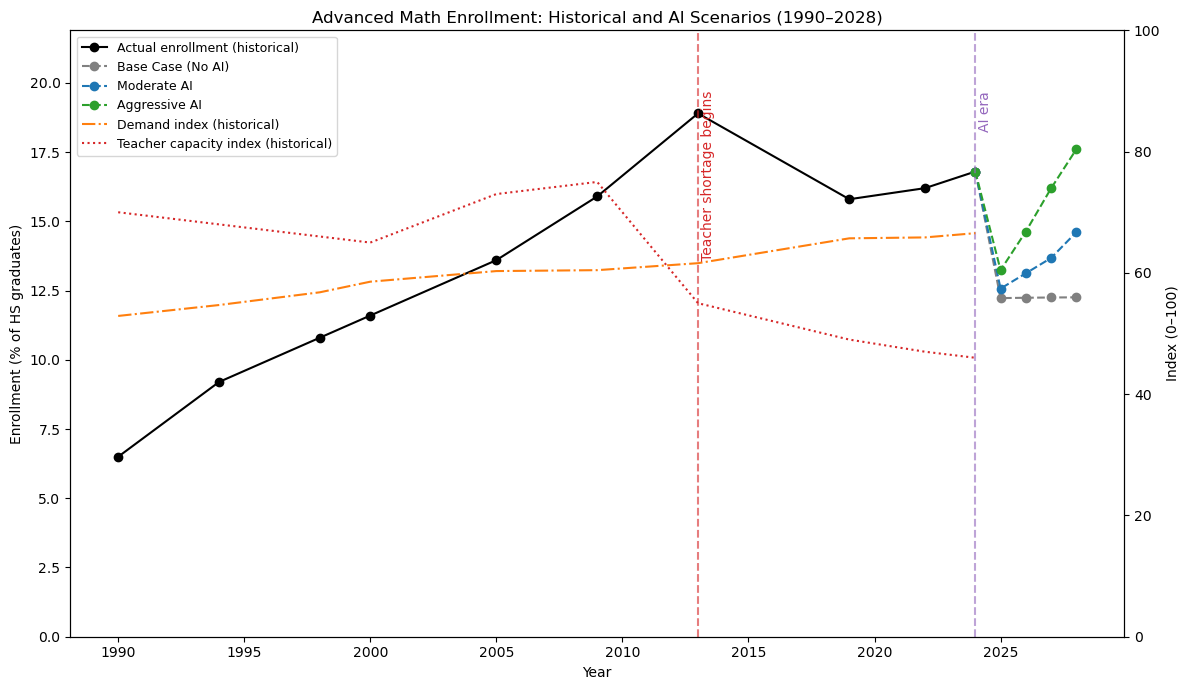

In [21]:
import matplotlib.pyplot as plt

all_projections = []

for scenario_key, scenario in scenarios.items():
    for i, year in enumerate(projection_years):
        enrollment, demand, constraint = predict_enrollment_scenario(
            scenario['stem_job_demand'][i],
            scenario['college_calc_preference'][i],
            scenario['math_anxiety_barrier'][i],
            scenario['auto_enrollment_push'][i],
            scenario['student_pool_size'][i],
            scenario['teacher_capacity'][i],
            scenario['tech_infrastructure'][i]
        )
        all_projections.append({
            'Scenario': scenario_key,
            'Year': year,
            'Enrollment': enrollment,
            'Demand_Index': demand,
            'Constraint': constraint
        })

proj_df = pd.DataFrame(all_projections)

# 2. Prepare series for plotting
years_hist = historical_data['year'].values
enroll_hist = historical_data['calculus_pct'].values
demand_hist = historical_data['demand_index'].values
teacher_hist = historical_data['teacher_capacity'].values

# Get scenario-specific future series (2024 anchor + 2025–2028)
def get_scenario_series(scenario_key):
    df = proj_df[proj_df['Scenario'] == scenario_key].sort_values('Year')
    years = np.concatenate([[2024], df['Year'].values])
    # 2024 baseline enrollment = historical actual
    base_2024 = historical_data.loc[historical_data['year'] == 2024, 'calculus_pct'].iloc[0]
    enroll = np.concatenate([[base_2024], df['Enrollment'].values])
    return years, enroll

yrs_base, y_base = get_scenario_series('base_case')
yrs_mod, y_mod = get_scenario_series('moderate_ai')
yrs_agg, y_agg = get_scenario_series('aggressive_ai')

# 3. Plot combined visualization
plt.figure(figsize=(12, 7))

# Left axis: enrollment (%)
ax1 = plt.gca()
ax1.set_title("Advanced Math Enrollment: Historical and AI Scenarios (1990–2028)")
ax1.set_xlabel("Year")
ax1.set_ylabel("Enrollment (% of HS graduates)")

# Historical actual
ax1.plot(years_hist, enroll_hist, color="black", marker="o", linestyle="-",
         label="Actual enrollment (historical)")

# Future scenarios
ax1.plot(yrs_base, y_base, color="gray", linestyle="--", marker="o",
         label="Base Case (No AI)")
ax1.plot(yrs_mod, y_mod, color="tab:blue", linestyle="--", marker="o",
         label="Moderate AI")
ax1.plot(yrs_agg, y_agg, color="tab:green", linestyle="--", marker="o",
         label="Aggressive AI")

ax1.set_ylim(0, max(max(enroll_hist), max(y_agg)) + 3)

# Right axis: indices (demand & teacher capacity)
ax2 = ax1.twinx()
ax2.set_ylabel("Index (0–100)")

ax2.plot(years_hist, demand_hist, color="tab:orange", linestyle="-.",
         label="Demand index (historical)")
ax2.plot(years_hist, teacher_hist, color="tab:red", linestyle=":",
         label="Teacher capacity index (historical)")

ax2.set_ylim(0, 100)

# Vertical reference lines
ax1.axvline(2013, color="tab:red", linestyle="--", alpha=0.6)
ax1.text(2013 + 0.1, ax1.get_ylim()[1] * 0.9, "Teacher shortage begins",
         rotation=90, color="tab:red", va="top")

ax1.axvline(2024, color="tab:purple", linestyle="--", alpha=0.6)
ax1.text(2024 + 0.1, ax1.get_ylim()[1] * 0.9, "AI era",
         rotation=90, color="tab:purple", va="top")

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left", fontsize=9)

plt.tight_layout()
plt.show()
